In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'mvn_exp_25b555f93a518efa82dad2e30bdbe8f8' in c['name'] 
        and c['generator'] == 'DDPM'
        # and c['config']['dataset']['set_size'] == 500
]

In [3]:
cfgs

[{'name': 'mvn_exp_25b555f93a518efa82dad2e30bdbe8f8',
  'dir': '../outputs/mvn_exp_25b555f93a518efa82dad2e30bdbe8f8',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultivariateNormalDistributionDataset', 'n_sets': 50000, 'set_size': '${experiment.set_size}', 'data_shape': [2], 'seed': '${seed}', 'prior_mu': [0, 5], 'prior_cov_df': 10, 'prior_cov_scale': 1}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderGNN', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 2, 'fc_layers': 2}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 16, 1], 'hidden_dim': 64, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.lr}'

In [4]:
import hydra
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [5]:
ds = prepare_dataset(cfgs[0]['config']['dataset'])

In [6]:
s1 = ds.sample(ds.mu[2][None, :], ds.cov[2][None, :, :], 1, 1_000_000, (2,)).squeeze()
s2 = ds.sample(ds.mu[1][None, :], ds.cov[1][None, :, :], 1, 1_000_000, (2,)).squeeze()

In [7]:
import numpy as np
import torch
lat = enc(torch.from_numpy(np.concatenate([s1[None, :, :], s2[None, :, :]], axis=0)).float().to(device))
# resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 20)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)


In [8]:
import numpy as np

# X is (n, m, d)
def vectorized_covariance(X):
    # Center the data
    X_centered = X - X.mean(axis=1, keepdims=True)  # shape (n, m, d)

    # Compute covariance: cov = (X^T X) / (m - 1)
    cov = np.einsum('nmd,nme->nde', X_centered, X_centered) / (X.shape[1] - 1)
    return cov


# compute means and covariances of all the resampled points
resample_means = np.mean(resample.cpu().numpy(), axis=1)
resample_covs = vectorized_covariance(resample.cpu().numpy())

In [9]:
import numpy as np
from scipy.linalg import sqrtm

import numpy as np
from scipy.linalg import sqrtm

def generate_ot_trajectory(mean1, cov1, mean2, cov2, n_steps=10):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2 : array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    mean1 = np.array(mean1)
    mean2 = np.array(mean2)
    cov1 = np.array(cov1)
    cov2 = np.array(cov2)
    
    # Generate interpolation parameters
    ts = np.linspace(0, 1, n_steps)
    
    # Initialize lists for means and covariances
    means = []
    covs = []
    
    # Compute the square root of cov1
    sqrt_cov1 = sqrtm(cov1)
    inv_sqrt_cov1 = np.linalg.inv(sqrt_cov1)
    
    # Compute A = (cov1^(1/2) * cov2 * cov1^(1/2))^(1/2)
    A = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    
    for t in ts:
        # Interpolate means linearly
        mean_t = (1 - t) * mean1 + t * mean2
        
        # Correct interpolation formula for covariances
        inner = ((1 - t) * cov1 + t * sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1))
        cov_t = inv_sqrt_cov1 @ (inner @ inner) @ inv_sqrt_cov1
        
        means.append(mean_t)
        covs.append(cov_t)
    
    return np.array(means), np.array(covs)

ot_means, ot_covs = generate_ot_trajectory(ds.mu[2], ds.cov[2], ds.mu[1], ds.cov[1], 20)

In [4]:
# load from numerical results
ot_means, ot_covs = np.load('../numerical_results/mvn_ot.npz')['ot_means'], np.load('../numerical_results/mvn_ot.npz')['ot_covs']
resample_means, resample_covs = np.load('../numerical_results/mvn_ot.npz')['gde_means'], np.load('../numerical_results/mvn_ot.npz')['gde_covs']

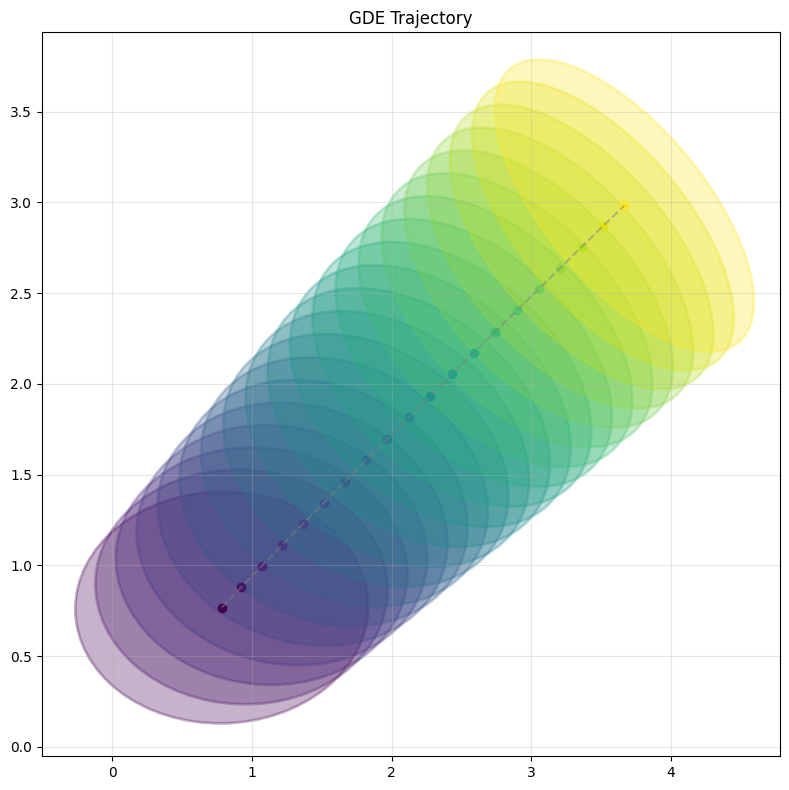

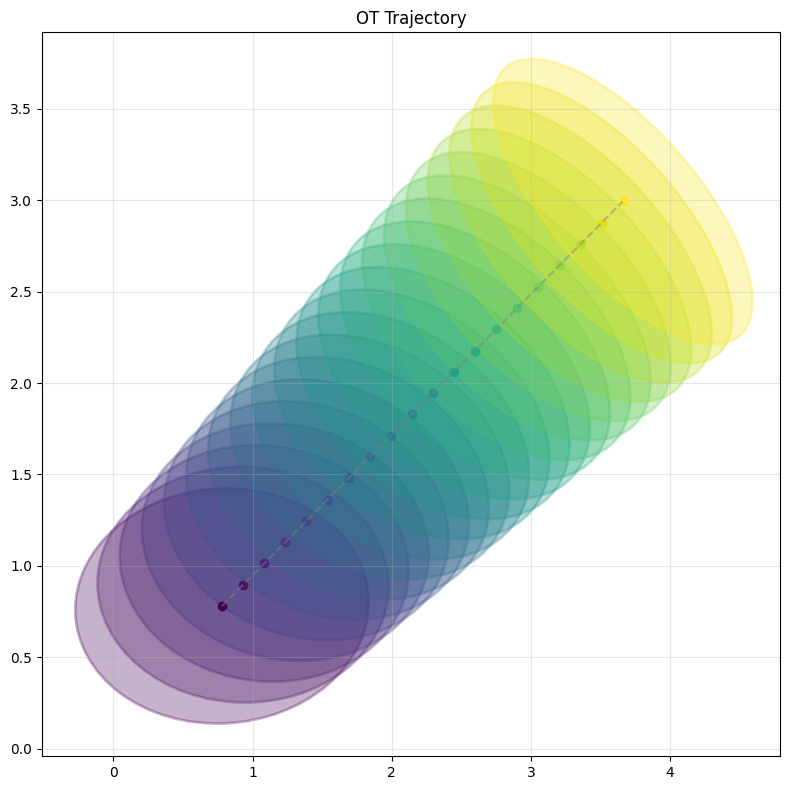

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

def plot_gaussian_trajectories(means, covs, figsize=(8, 8), alpha=0.3, n_std=2, title=None):
    """
    Plot trajectories of Gaussian distributions with their confidence ellipses.
    
    Parameters:
    -----------
    means : array-like
        List of 2D means, shape (n_timesteps, 2)
    covs : array-like
        List of 2x2 covariance matrices, shape (n_timesteps, 2, 2)
    figsize : tuple
        Figure size (width, height)
    alpha : float
        Transparency of ellipses
    n_std : float
        Number of standard deviations for ellipse size
    """
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    
    # Plot trajectories and ellipses
    for i in range(len(means)):
        mean = means[i]
        cov = covs[i]
        
        # Calculate eigenvalues and eigenvectors
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        
        # Calculate angle and axes lengths for ellipse
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        width, height = 2 * n_std * np.sqrt(eigenvals)
        
        # Create and add ellipse
        ellipse = Ellipse(xy=mean,
                         width=width,
                         height=height,
                         angle=angle,
                         facecolor=colors[i],
                         alpha=alpha,
                         edgecolor=colors[i],
                         linewidth=2)
        ax.add_patch(ellipse)
        
        # Plot mean point
        ax.plot(mean[0], mean[1], 'o', color=colors[i], markersize=6)
        
    # Plot trajectory line
    means_array = np.array(means)
    ax.plot(means_array[:, 0], means_array[:, 1], '--', color='gray', alpha=0.5)
    
    # Set equal aspect ratio and grid
    # ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar to show time progression
    # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
    #                           norm=plt.Normalize(vmin=0, vmax=len(means)-1))
    
    # plt.colorbar(sm, ax=ax, label='Time step')  # Added ax=ax here

    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    
    return fig


fig = plot_gaussian_trajectories(resample_means, resample_covs, title='GDE Trajectory')
plt.savefig('../figs/mvn_gde.png', dpi=300)

fig_ot = plot_gaussian_trajectories(ot_means, ot_covs, title='OT Trajectory')
plt.savefig('../figs/mvn_ot.png', dpi=300)

# save actual data to numerical results
np.savez(
    '../numerical_results/mvn_ot.npz', 
    ot_means=ot_means, 
    ot_covs=ot_covs, 
    gde_means=resample_means, 
    gde_covs=resample_covs
)
